# Test scipy.signal.correlate on some atl06 data from foundation ice stream

In [1]:
import numpy as np
import scipy, sys, os, pyproj, glob, re, h5py
import matplotlib.pyplot as plt

from scipy.signal import correlate
from astropy.time import Time

%matplotlib widget
%load_ext autoreload
%autoreload 2

# Test scipy.signal.correlate

Generate some test data:

In [2]:
dx = 0.1
x = np.arange(0,10,dx)
y = np.zeros(np.shape(x))
ix0 = 30
ix1 = 30 + 15
y[ix0:ix1] = 1

fig,axs = plt.subplots(1,2)
axs[0].plot(x,y,'k')
axs[0].set_xlabel('distance (m)')
axs[0].set_ylabel('value')
axs[1].plot(np.arange(len(x)), y,'k')
axs[1].set_xlabel('index')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'index')

Make a signal to correlate with:

In [3]:
imposed_offset = int(14/dx) # 14 meters, in units of samples

x_noise = np.arange(0,50,dx) # make the vector we're comparing with much longer
y_noise = np.zeros(np.shape(x_noise))
y_noise[ix0 + imposed_offset : ix1 + imposed_offset] = 1

# uncomment the line below to add noise
# y_noise = y_noise * np.random.random(np.shape(y_noise))

fig,axs = plt.subplots(1,2)

axs[0].plot(x,y,'k')
axs[0].set_xlabel('distance (m)')
axs[0].set_ylabel('value')
axs[1].plot(np.arange(len(x)), y, 'k')
axs[1].set_xlabel('index')

axs[0].plot(x_noise,y_noise, 'b')
axs[0].set_xlabel('distance (m)')
axs[0].set_ylabel('value')
axs[1].plot(np.arange(len(x_noise)), y_noise,'b')
axs[1].set_xlabel('index')

fig.suptitle('black = original, blue = shifted')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0.98, 'black = original, blue = shifted')

Try scipy.signal.correlate:

mode ='full' returns the entire cross correlation; could be 'valid' to return only non- zero-padded part

method = direct (not fft)

In [4]:
corr = correlate(y_noise,y, mode = 'full', method = 'direct') 
norm_val = np.sqrt(np.sum(y_noise**2)*np.sum(y**2))
corr = corr / norm_val

What are the dimensions of corr?

In [5]:
print('corr: ', np.shape(corr))
print('x: ', np.shape(x))
print('x: ', np.shape(x_noise))

corr:  (599,)
x:  (100,)
x:  (500,)


In [6]:
# lagvec = np.arange(0,len(x_noise) - len(x) + 1)
lagvec = np.arange( -(len(x) - 1), len(x_noise), 1)
shift_vec = lagvec * dx

ix_peak = np.arange(len(corr))[corr == np.nanmax(corr)][0]
best_lag = lagvec[ix_peak]
best_shift = shift_vec[ix_peak]

fig,axs = plt.subplots(3,1)

axs[0].plot(lagvec,corr)
axs[0].plot(lagvec[ix_peak],corr[ix_peak], 'r*')
axs[0].set_xlabel('lag (samples)')
axs[0].set_ylabel('correlation coefficient')

axs[1].plot(shift_vec,corr)
axs[1].plot(shift_vec[ix_peak],corr[ix_peak], 'r*')
axs[1].set_xlabel('shift (m)')
axs[1].set_ylabel('correlation coefficient')

axs[2].plot(x + best_shift, y,'k')
axs[2].plot(x_noise, y_noise, 'b--')
axs[2].set_xlabel('shift (m)')


fig.suptitle(' '.join(['Shift ', str(best_lag), ' samples, or ', str(best_shift), ' m to line up signals']))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0.98, 'Shift  140  samples, or  14.0  m to line up signals')

# Let's try with some ATL06 data

Load some repeat data:


import readers, etc

In [7]:
#! cd ..; [ -d pointCollection ] || git clone https://www.github.com/smithB/pointCollection.git
#sys.path.append(os.path.join(os.getcwd(), '..'))

#!python3 -m pip install --user git+https://github.com/tsutterley/pointCollection.git@pip
import pointCollection as pc

In [8]:
moa_datapath = '/srv/tutorial-data/land_ice_applications/'
datapath = '/home/jovyan/shared/surface_velocity/FIS_ATL06/'


In [9]:
# example hf5 file, if you need to look at the fields
# datapath='/home/jovyan/shared/surface_velocity/FIS_ATL06_small/processed_ATL06_20191129105346_09700511_003_01.h5'
# !h5ls -r /home/jovyan/shared/surface_velocity/FIS_ATL06_small/processed_ATL06_20191129105346_09700511_003_01.h5

# Geographic setting : Foundation Ice Stream

In [10]:
print(pc.__file__)

/home/jovyan/.local/lib/python3.7/site-packages/pointCollection/__init__.py


In [11]:
# something wrong with pointCollection

spatial_extent = np.array([-102, -76, -98, -74.5])
lat=spatial_extent[[1, 3, 3, 1, 1]]
lon=spatial_extent[[2, 2, 0, 0, 2]]
print(lat)
print(lon)
# project the coordinates to Antarctic polar stereographic
xy=np.array(pyproj.Proj(3031)(lon, lat))
# get the bounds of the projected coordinates 
XR=[np.nanmin(xy[0,:]), np.nanmax(xy[0,:])]
YR=[np.nanmin(xy[1,:]), np.nanmax(xy[1,:])]
MOA=pc.grid.data().from_geotif(os.path.join(moa_datapath, 'MOA','moa_2009_1km.tif'), bounds=[XR, YR])

# show the mosaic:
plt.figure()
MOA.show(cmap='gray', clim=[14000, 17000])
plt.plot(xy[0,:], xy[1,:])
plt.title('Mosaic of Antarctica for Pine Island Glacier')

[-76.  -74.5 -74.5 -76.  -76. ]
[ -98.  -98. -102. -102.  -98.]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'cmap': 'gray', 'clim': [14000, 17000], 'extent': array([-1676950., -1495950.,  -352175.,  -213175.]), 'origin': 'lower'}


Text(0.5, 1.0, 'Mosaic of Antarctica for Pine Island Glacier')

# Load repeat track data

ATL06 reader

In [12]:
def atl06_to_dict(filename, beam, field_dict=None, index=None, epsg=None):
    """
        Read selected datasets from an ATL06 file

        Input arguments:
            filename: ATl06 file to read
            beam: a string specifying which beam is to be read (ex: gt1l, gt1r, gt2l, etc)
            field_dict: A dictinary describing the fields to be read
                    keys give the group names to be read, 
                    entries are lists of datasets within the groups
            index: which entries in each field to read
            epsg: an EPSG code specifying a projection (see www.epsg.org).  Good choices are:
                for Greenland, 3413 (polar stereographic projection, with Greenland along the Y axis)
                for Antarctica, 3031 (polar stereographic projection, centered on the Pouth Pole)
        Output argument:
            D6: dictionary containing ATL06 data.  Each dataset in 
                dataset_dict has its own entry in D6.  Each dataset 
                in D6 contains a numpy array containing the 
                data
    """
    if field_dict is None:
        field_dict={None:['latitude','longitude','h_li', 'atl06_quality_summary'],\
                    'ground_track':['x_atc','y_atc'],\
                    'fit_statistics':['dh_fit_dx', 'dh_fit_dy']}
    D={}
    # below: file_re = regular expression, it will pull apart the regular expression to get the information from the filename
    file_re=re.compile('ATL06_(?P<date>\d+)_(?P<rgt>\d\d\d\d)(?P<cycle>\d\d)(?P<region>\d\d)_(?P<release>\d\d\d)_(?P<version>\d\d).h5')
    with h5py.File(filename,'r') as h5f:
        for key in field_dict:
            for ds in field_dict[key]:
                if key is not None:
                    ds_name=beam+'/land_ice_segments/'+key+'/'+ds
                else:
                    ds_name=beam+'/land_ice_segments/'+ds
                if index is not None:
                    D[ds]=np.array(h5f[ds_name][index])
                else:
                    D[ds]=np.array(h5f[ds_name])
                if '_FillValue' in h5f[ds_name].attrs:
                    bad_vals=D[ds]==h5f[ds_name].attrs['_FillValue']
                    D[ds]=D[ds].astype(float)
                    D[ds][bad_vals]=np.NaN
        D['data_start_utc'] = h5f['/ancillary_data/data_start_utc'][:]
        D['delta_time'] = h5f['/' + beam + '/land_ice_segments/delta_time'][:]
        D['segment_id'] = h5f['/' + beam + '/land_ice_segments/segment_id'][:]
    if epsg is not None:
        xy=np.array(pyproj.proj.Proj(epsg)(D['longitude'], D['latitude']))
        D['x']=xy[0,:].reshape(D['latitude'].shape)
        D['y']=xy[1,:].reshape(D['latitude'].shape)
    temp=file_re.search(filename)
    D['rgt']=int(temp['rgt'])
    D['cycle']=int(temp['cycle'])
    D['beam']=beam
    return D

Read in files; this next cell took ~1 minute early in the morning

In [13]:
# find all the files in the directory:
# ATL06_files=glob.glob(os.path.join(datapath, 'PIG_ATL06', '*.h5'))

ATL06_files=glob.glob(os.path.join(datapath, '*.h5'))

D_dict={}
error_count=0
for file in ATL06_files:
    try:
        D_dict[file]=atl06_to_dict(file, '/gt2l', index=slice(0, -1, 25), epsg=3031)
    except KeyError as e:
        print(f'file {file} encountered error {e}')
        error_count += 1
print(f"read {len(D_dict)} data files of which {error_count} gave errors")

file /home/jovyan/shared/surface_velocity/FIS_ATL06/processed_ATL06_20190430122344_04920311_003_01.h5 encountered error 'Unable to open object (component not found)'
file /home/jovyan/shared/surface_velocity/FIS_ATL06/processed_ATL06_20181030210407_04920111_003_01.h5 encountered error 'Unable to open object (component not found)'
file /home/jovyan/shared/surface_velocity/FIS_ATL06/processed_ATL06_20190730080323_04920411_003_01.h5 encountered error 'Unable to open object (component not found)'
file /home/jovyan/shared/surface_velocity/FIS_ATL06/processed_ATL06_20190220230230_08320211_003_01.h5 encountered error 'Unable to open object (component not found)'
file /home/jovyan/shared/surface_velocity/FIS_ATL06/processed_ATL06_20190312235510_11380211_003_01.h5 encountered error 'Unable to open object (component not found)'
file /home/jovyan/shared/surface_velocity/FIS_ATL06/processed_ATL06_20181108184743_06280111_003_01.h5 encountered error 'Unable to open object (component not found)'
file

Plot ground tracks

In [17]:
plt.figure(figsize=[8,8])
hax0=plt.gcf().add_subplot(211, aspect='equal')
MOA.show(ax=hax0, cmap='gray', clim=[14000, 17000]);
hax1=plt.gcf().add_subplot(212, aspect='equal', sharex=hax0, sharey=hax0)
MOA.show(ax=hax1, cmap='gray', clim=[14000, 17000]);
for fname, Di in D_dict.items():
    cycle=Di['cycle']
    if cycle <= 2:
        ax=hax0
    else:
        ax=hax1
    #print(fname)
    #print(f'\t{rgt}, {cycle}, {region}')
    ax.plot(Di['x'], Di['y'])
    if True:
        try:
            if cycle  < 3:
                ax.text(Di['x'][0], Di['y'][0], f"rgt={Di['rgt']}, cyc={cycle}", clip_on=True)
            elif cycle==3:
                ax.text(Di['x'][0], Di['y'][0], f"rgt={Di['rgt']}, cyc={cycle}+", clip_on=True)
        except IndexError:
            pass
hax0.set_title('cycles 1 and 2');
hax1.set_title('cycle 3+');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'cmap': 'gray', 'clim': [14000, 17000], 'extent': array([-1676950., -1495950.,  -352175.,  -213175.]), 'origin': 'lower'}
{'cmap': 'gray', 'clim': [14000, 17000], 'extent': array([-1676950., -1495950.,  -352175.,  -213175.]), 'origin': 'lower'}


Map view elevations

In [15]:
map_fig=plt.figure()
map_ax=map_fig.add_subplot(111)
# MOA.show(ax=map_ax, cmap='gray', clim=[14000, 17000])
for fname, Di in D_dict.items():
    # select elevations with good quality_summary
    good=Di['atl06_quality_summary']==0
    ms=map_ax.scatter( Di['x'][good], Di['y'][good],  2, c=Di['h_li'][good], \
                  vmin=0, vmax=1000, label=fname)
map_ax._aspect='equal'
plt.colorbar(ms, label='elevation');



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Repeat track elevation profile

In [18]:
# Ben Smiths's code to plot the individual segments:
def plot_segs(D6, ind=None, **kwargs):
    """
    Plot a sloping line for each ATL06 segment
    """
    if ind is None:
        ind=np.ones_like(D6['h_li'], dtype=bool)
    #define the heights of the segment endpoints.  Leave a row of NaNs so that the endpoints don't get joined
    h_ep=np.zeros([3, D6['h_li'][ind].size])+np.NaN
    h_ep[0, :]=D6['h_li'][ind]-D6['dh_fit_dx'][ind]*20
    h_ep[1, :]=D6['h_li'][ind]+D6['dh_fit_dx'][ind]*20
    # define the x coordinates of the segment endpoints
    x_ep=np.zeros([3,D6['h_li'][ind].size])+np.NaN
    x_ep[0, :]=D6['x_atc'][ind]-20
    x_ep[1, :]=D6['x_atc'][ind]+20

    plt.plot(x_ep.T.ravel(), h_ep.T.ravel(), **kwargs)

In [19]:
# A revised code to plot the elevations of segment midpoints (h_li):
def plot_elevation(D6, ind=None, **kwargs):
    """
    Plot midpoint elevation for each ATL06 segment
    """
    if ind is None:
        ind=np.ones_like(D6['h_li'], dtype=bool)
    # pull out heights of segment midpoints
    h_li = D6['h_li'][ind]
    # pull out along track x coordinates of segment midpoints
    x_atc = D6['x_atc'][ind]

    plt.plot(x_atc, h_li, **kwargs)

In [20]:
D_2l={}
D_2r={}

# specify the rgt here:
rgt="0027"
rgt="0848" #Ben's suggestion

# iterate over the repeat cycles
for cycle in ['03','04','05','06','07']:
    for filename in glob.glob(os.path.join(datapath, f'*ATL06_*_{rgt}{cycle}*_003*.h5')):
        try:
            # read the left-beam data
            D_2l[filename]=atl06_to_dict(filename,'/gt2l', index=None, epsg=3031)
            # read the right-beam data
            D_2r[filename]=atl06_to_dict(filename,'/gt2r', index=None, epsg=3031)
            # plot the locations in the previous plot
            map_ax.plot(D_2r[filename]['x'], D_2r[filename]['y'],'k');  
            map_ax.plot(D_2l[filename]['x'], D_2l[filename]['y'],'k');
        except Exception as e:
            print(f'filename={filename}, exception={e}')

plt.figure();
for filename, Di in D_2l.items():
    #Plot only points that have ATL06_quality_summary==0 (good points)
    hl=plot_elevation(Di, ind=Di['atl06_quality_summary']==0, label=f"cycle={Di['cycle']}")
    #hl=plt.plot(Di['x_atc'][Di['atl06_quality_summary']==0], Di['h_li'][Di['atl06_quality_summary']==0], '.', label=f"cycle={Di['cycle']}")
    
plt.legend()
plt.xlabel('x_atc')
plt.ylabel('elevation');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Pull out a segment and cross correlate: 

Let's try x_atc = 2.935e7 thru 2.93e7 (just from looking through data)


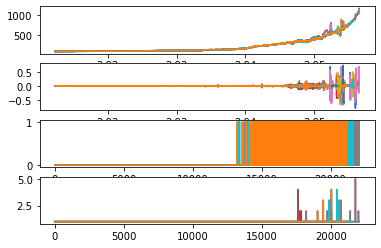

In [112]:

cycles = [] # names of cycles with data
for filename, Di in D_2l.items():
    cycles += [str(Di['cycle']).zfill(2)]
cycles.sort()
    
# x1 = 2.93e7
# x2 = 2.935e7

beams = ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']

### extract and plot data from all available cycles
fig, axs = plt.subplots(4,1)
x_atc = {}
h_li = {}
h_li_diff = {}
times = {}

for cycle in cycles:
    # find Di that matches cycle:
    Di = {}
    x_atc[cycle] = {}
    h_li[cycle] = {}
    h_li_diff[cycle] = {}
    times[cycle] = {}

    filenames = glob.glob(os.path.join(datapath, f'*ATL06_*_{rgt}{cycle}*_003*.h5'))
    for filename in filenames:
        try:
            for beam in beams:
                Di[filename]=atl06_to_dict(filename,'/'+ beam, index=None, epsg=3031)

                times[cycle][beam] = Di[filename]['data_start_utc']
                
                # extract h_li and x_atc for that section
                x_atc_tmp = Di[filename]['x_atc']
                h_li_tmp = Di[filename]['h_li']#[ixs]
                
                # segment ids:
                seg_ids = Di[filename]['segment_id']
#                 print(len(seg_ids), len(x_atc_tmp))
                
                # make a monotonically increasing x vector
                # assumes dx = 20 exactly, so be carefull referencing back
                ind = seg_ids - np.nanmin(seg_ids) # indices starting at zero, using the segment_id field, so any skipped segment will be kept in correct location
                x_full = np.arange(np.max(ind)+1) * 20 + x_atc_tmp[0]
                h_full = np.zeros(np.max(ind)+1) + np.NaN
                h_full[ind] = h_li_tmp
                
                
                x_atc[cycle][beam] = x_full
                h_li[cycle][beam] = h_full
                  
                                            
#                 ### here is where you would put a filter
#                 # you would want to de-mean and detrend that section first:
#                 h = h_full
#                 x = x_full
#                 h = h - np.nanmean(h) # de-mean
#                 h = scipy.signal.detrend(h, type = 'linear') # de-trend; need to deal with nans first
#                 # use scipy.signal.filter to filter

#                 # differentiate that section of data
                h_diff = (h_full[1:] - h_full[0:-1]) / (x_full[1:] - x_full[0:-1])
                h_li_diff[cycle][beam] = h_diff

                # plot
                axs[0].plot(x_full, h_full)
                axs[1].plot(x_full[1:], h_diff)
#                 axs[2].plot(x_atc_tmp[1:] - x_atc_tmp[:-1])
                axs[2].plot(np.isnan(h_full))
                axs[3].plot(seg_ids[1:]- seg_ids[:-1])



        except:
            print(f'filename={filename}, exception={e}')


            

oops! Not all cycles in beam gt1r are the same length. Trimming
oops! Not all cycles in beam gt3l are the same length. Trimming


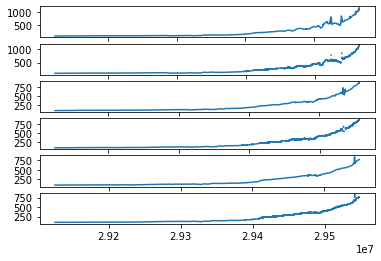

In [113]:
# Average together all cycles for each beam
h_li_avg = {}

avgSurfFig, avgSurfAx = plt.subplots(len(beams),1)
avgSurfAxCount = 0
for beam in beams:
    
    # if cycles for a given beam are not of the same length, trim ends
    cycle_length = np.zeros(len(cycles))
    for cycleInd in np.arange(0, len(cycles)):
        cycle_length[cycleInd] = len(x_atc[cycles[cycleInd]][beam])
    
    if np.any(cycle_length != cycle_length[0]):
        print('oops! Not all cycles in beam {} are the same length. Trimming'.format(beam))
        long_cycle = int(np.where(cycle_length == np.max(cycle_length))[0]) # identify which is longer. np.where returns a tuple of arrays, so index 0
        short_cycle = int(np.where(cycle_length != np.max(cycle_length))[0])
        if x_atc[cycles[long_cycle]][beam][0] is not x_atc[cycles[short_cycle]][beam][0]: #trim beginning of array
            trimmed_x_atc = x_atc[cycles[long_cycle]][beam][1:]
            trimme_h_li = h_li[cycles[long_cycle]][beam][1:]
        
        if x_atc[cycles[long_cycle]][beam][-1] is not x_atc[cycles[short_cycle]][beam][-1]: #trim end of array
            trimmed_x_atc = x_atc[cycles[long_cycle]][beam][:-1]
            trimmed_h_li = h_li[cycles[long_cycle]][beam][:-1]
            
        h_li[cycles[long_cycle]][beam] = trimmed_h_li
        x_atc[cycles[long_cycle]][beam] = trimmed_x_atc
        
        
    # average h_li across all cycles for the beam
    cycleSum = np.zeros(np.shape(x_atc[cycles[0]][beam]))
    cycleCount = 0.
    for cycle in cycles:
        cycleSum += h_li[cycle][beam]
        cycleCount += 1.
    
    h_li_avg[beam] = cycleSum / cycleCount 
    
    # plot up average surface for each beam
    avgSurfAx[avgSurfAxCount].plot(x_atc[cycles[0]][beam], h_li_avg[beam]) 
    avgSurfAxCount += 1
    
    #subtract average surface off all cycles for each beam
    for cycle in cycles:
        h_li[cycle][beam] -= h_li_avg[beam]
          

ValueError: x and y must have same first dimension, but have shapes (21161,) and (21615,)

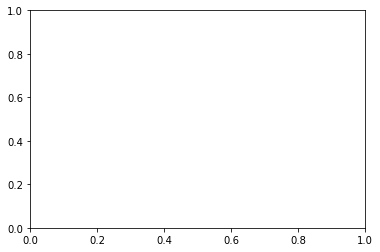

In [114]:
plt.plot(x_atc[cycles[0]][beam], h_li[cycles[0]][beams[3]])
plt.show()

In [42]:
n_veloc = len(cycles) - 1

segment_length = 10000 # m
x1 = 2.915e7#x_atc[cycles[0]][beams[0]][1000] <-- the very first x value in a file; doesn't work, I think b/c nans # 2.93e7

search_width = 2000 # m
dx = 20 # meters between x_atc points

for veloc_number in range(n_veloc):
    cycle1 = cycles[veloc_number]
    cycle2 = cycles[veloc_number+1]
    t1_string = times[cycle1]['gt1l'][0].astype(str) #figure out later if just picking hte first one it ok
    t1 = Time(t1_string)
                       
    t2_string = times[cycle2]['gt1l'][0].astype(str) #figure out later if just picking hte first one it ok
    t2 = Time(t2_string)
    
    dt = (t2 - t1).jd # difference in julian days
        
    velocities = {}     
    for beam in beams:
        fig1, axs = plt.subplots(4,1)
        
        # cut out small chunk of data at time t1 (first cycle)
        x_full_t1 = x_atc[cycle1][beam]
        ix_x1 = np.arange(len(x_full_t1))[x_full_t1 >= x1][0]
        ix_x2 = ix_x1 + int(np.round(segment_length/dx))      
        x_t1 = x_full_t1[ix_x1:ix_x2]
        h_li1 = h_li_diff[cycle1][beam][ix_x1-1:ix_x2-1] # start 1 index earlier because the data are differentiated
        
        # cut out a wider chunk of data at time t2 (second cycle)
        x_full_t2 = x_atc[cycle2][beam]
        ix_x3 = ix_x1 - int(np.round(search_width/dx)) # offset on earlier end by # indices in search_width
        ix_x4 = ix_x2 + int(np.round(search_width/dx)) # offset on later end by # indices in search_width
        x_t2 = x_full_t2[ix_x3:ix_x4]
        h_li2 = h_li_diff[cycle2][beam][ix_x3:ix_x4]

        # plot data
        axs[0].plot(x_t2, h_li2, 'r')
        axs[0].plot(x_t1, h_li1, 'k')
        axs[0].set_xlabel('x_atc (m)')
        
        # correlate old with newer data
        corr = correlate(h_li1, h_li2, mode = 'valid', method = 'direct') 
        norm_val = np.sqrt(np.sum(h_li1**2)*np.sum(h_li2**2)) # normalize so values range between 0 and 1
        corr = corr / norm_val
        
        
#         lagvec = np.arange( -(len(h_li1) - 1), len(h_li2), 1)# for mode = 'full'
#         lagvec = np.arange( -int(search_width/dx) - 1, int(search_width/dx) +1, 1) # for mode = 'valid'
        lagvec = np.arange(- int(np.round(search_width/dx)), int(search_width/dx) +1,1)# for mode = 'valid'

        shift_vec = lagvec * dx

        ix_peak = np.arange(len(corr))[corr == np.nanmax(corr)][0]
        best_lag = lagvec[ix_peak]
        best_shift = shift_vec[ix_peak]
        velocities[beam] = best_shift/(dt/365)

        axs[1].plot(lagvec,corr)
        axs[1].plot(lagvec[ix_peak],corr[ix_peak], 'r*')
        axs[1].set_xlabel('lag (samples)')

        axs[2].plot(shift_vec,corr)
        axs[2].plot(shift_vec[ix_peak],corr[ix_peak], 'r*')
        axs[2].set_xlabel('shift (m)')

        # plot shifted data
        axs[3].plot(x_t2, h_li2, 'r')
        axs[3].plot(x_t1 - best_shift, h_li1, 'k')
        axs[3].set_xlabel('x_atc (m)')
        
        axs[0].text(x_t2[100], 0.6*np.nanmax(h_li2), beam)
        axs[1].text(lagvec[5], 0.6*np.nanmax(corr), 'best lag: ' + str(best_lag) + '; corr val: ' + str(np.round(corr[ix_peak],3)))
        axs[2].text(shift_vec[5], 0.6*np.nanmax(corr), 'best shift: ' + str(best_shift) + ' m'+ '; corr val: ' + str(np.round(corr[ix_peak],3)))
        axs[2].text(shift_vec[5], 0.3*np.nanmax(corr), 'veloc of ' + str(np.round(best_shift/(dt/365),1)) + ' m/yr')

        
    fig1.suptitle('black = older cycle data, red = newer cycle data to search across')


        
        

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …